<a href="https://colab.research.google.com/github/jongkwangyun/quant/blob/main/%EB%8F%99%EC%A0%81%EC%9E%90%EC%82%B0%EB%B0%B0%EB%B6%84(%2B%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8A%B8)_RAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

In [3]:
!pip install pandas_market_calendars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 19.0 MB/s eta 0:00:00


In [4]:
!pip install fredapi

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, Markdown
import csv
from fredapi import Fred
import json

# display에서 소수점 4자리까지 표현
pd.options.display.float_format = '{:.4f}'.format

# display시 DataFrame 모든 열 표시
pd.set_option('display.max_columns', None)

# 데이터 가져올 기간을 지정합니다. (오늘로부터 12개월 전)
today = datetime.today().date()
# start_date = today - timedelta(days=375)

# 오늘 날짜 string에 저장
str_today = today.strftime('### %Y-%m-%d ')

# 전략명
str_strategy = 'RAA '

# 오늘 날짜를 가져와서 파일명에 추가
today_date = today.strftime('%y%m%d')
filename = f'{today_date} {str_strategy}.xlsx'

# csv 경로 설정
output_path =  '/content/drive/MyDrive/DynamicAssetAllocation/'

# 월평균영업일수. average Monthly Business Day
MBD = 21

# 데이터 csv 내보내기 사용 여부
is_export_csv = False

# 전략에 사용할 ETF 명 리스트에 담기
etf_stock = ['QQQ', 'IWN']
etf_bond = ['IEF', 'TLT']
etf_real = ['GLD']
etf_canary = ['VWO', 'BND']

# 자산군 리스트 더하기, 중복 제거
etf_order = list(set(etf_stock + etf_bond + etf_real + etf_canary))

# ETF 가격 추출
df_etf = yf.download(etf_order, end=today)['Adj Close']\
.sort_index(ascending=False)[etf_order].rename_axis(None, axis=0).dropna()
display(df_etf)

# 1개월씩 자르기
df_etf_monthly = df_etf[::MBD]

[*********************100%%**********************]  7 of 7 completed


,TLT,BND,GLD,IEF,VWO,QQQ,IWN
2023-10-06,84.7900,68.7800,169.7000,90.0700,39.1000,364.7000,132.1000
2023-10-05,85.8300,69.0500,168.8300,90.6000,38.5700,358.6900,131.3200
2023-10-04,86.2600,69.0000,169.1400,90.4300,38.4100,359.7500,130.9900
2023-10-03,85.0600,68.5500,169.1600,89.8600,38.5700,354.9200,131.0300
2023-10-02,86.9300,69.1100,169.6500,90.6100,39.0700,361.2600,133.1000
...,...,...,...,...,...,...,...
2007-04-16,54.1157,45.4076,68.4000,56.1097,26.9891,39.2397,60.1337
2007-04-13,53.8192,45.3652,67.8400,56.0485,26.6553,38.8827,59.3920
2007-04-12,53.9860,45.4379,66.9900,56.1438,26.5686,38.8043,59.0176
2007-04-11,53.9736,45.4440,67.0800,56.0893,26.2348,38.4995,58.6431


In [6]:
# api key 불러오기
api_key_data = ''

with open('/content/drive/My Drive/DynamicAssetAllocation/api_key.json') as f:
    api_key_data = json.load(f)


## DataFrame 만들기: 미국 실업률 (ex. 08-01: 8월1일~31일 실업률 통계)
fred = Fred(api_key=api_key_data['fred'])
fred_unrate = fred.get_series('UNRATE').sort_index(ascending=False)
df_fred_unrate = pd.DataFrame(fred_unrate, columns=['unemployment rate'])

str_fred_unrate = str_today + str_strategy + "### 미국 실업률"
display(Markdown(str_fred_unrate))
display(df_fred_unrate.head(5))

if is_export_csv:
    with open(output_path + filename, 'w') as f:
        f.write(f'{str_fred_unrate}\n')
        df_fred_unrate.head(5).to_csv(f, index=True)

### 2023-10-09 RAA ### 미국 실업률

,unemployment rate
2023-09-01,3.8000
2023-08-01,3.8000
2023-07-01,3.5000
2023-06-01,3.6000
2023-05-01,3.7000


In [7]:
# 인덱스 만들기
df_momentum_index = ['today/' + str(df_etf.index[0].date()), '1mo_ago/' + str(df_etf.index[MBD].date()), \
                     '3mo_ago/' + str(df_etf.index[MBD*3].date()), '6mo_ago/' + str(df_etf.index[MBD*6].date()), \
                     '12mo_ago/' + str(df_etf.index[MBD*12].date())]


## DataFrame 만들기: 1-3-6-12 개월 etf 가격
price_today = df_etf.iloc[0:1]
price_1mo = df_etf.shift(-MBD).iloc[0:1]
price_3mo = df_etf.shift(-MBD*3).iloc[0:1]
price_6mo = df_etf.shift(-MBD*6).iloc[0:1]
price_12mo = df_etf.shift(-MBD*12).iloc[0:1]

df_price = pd.concat([price_today, price_1mo, price_3mo, price_6mo, price_12mo])
df_price.index = df_momentum_index

str_etf_price = str_today + str_strategy + "### ETF 현재-1-3-6-12 개월 가격"
display(Markdown(str_etf_price))
display(df_price)

# csv에 제목 및 DataFrame 추가. 드라이브 마운트 후 해야함
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_etf_price}\n')
    df_price.to_csv(f, index=True)

### 2023-10-09 RAA ### ETF 현재-1-3-6-12 개월 가격

,TLT,BND,GLD,IEF,VWO,QQQ,IWN
today/2023-10-06,84.7900,68.7800,169.7000,90.0700,39.1000,364.7000,132.1000
1mo_ago/2023-09-07,93.7132,70.7847,178.0200,93.2460,39.7954,371.5222,139.5729
3mo_ago/2023-07-10,98.3300,71.1670,178.7800,94.3507,40.2616,365.8304,140.7647
6mo_ago/2023-04-06,106.7231,73.2811,186.4900,98.9967,39.9450,317.1552,132.1632
12mo_ago/2022-10-05,99.3597,69.4704,159.8100,93.6450,37.0146,280.0815,132.9258


In [8]:
## DataFrame 만들기: 모멘텀 스코어
df_etf_monthly_copy = df_etf_monthly.copy(deep=True)
df_etf_momentum_score = pd.DataFrame(index=df_etf_monthly.index, columns=df_etf_monthly.columns)

for i in range(0, len(df_etf_monthly) - 12):
  ror_1mo = df_etf_monthly_copy.pct_change(-1).iloc[0]  # 1개월 수익률
  ror_3mo = df_etf_monthly_copy.pct_change(-3).iloc[0]  # 3개월 수익률
  ror_6mo = df_etf_monthly_copy.pct_change(-6).iloc[0]  # 6개월 수익률
  ror_12mo = df_etf_monthly_copy.pct_change(-12).iloc[0]  # 12개월 수익률
  df_etf_monthly_copy.drop(df_etf_monthly_copy.index[0], inplace=True)

  # 가중치 더하기
  df_etf_momentum_score.iloc[i] = ((12 * ror_1mo) + (4 * ror_3mo) + (2 * ror_6mo) + (ror_12mo)) * 100

df_etf_momentum_score.dropna(inplace=True)

str_etf_momentum_score = str_today + str_strategy + "### ETF 별 1-3-6-12 개월 Momentum Score"
display(Markdown(str_etf_momentum_score))
display(df_etf_momentum_score)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_etf_momentum_score}\n')
    df_etf_momentum_score.head(5).to_csv(f, index=True)

### 2023-10-09 RAA ### ETF 별 1-3-6-12 개월 Momentum Score

,TLT,BND,GLD,IEF,VWO,QQQ,IWN
2023-10-06,-225.1082,-60.6798,-88.2168,-80.8732,-31.1065,36.9228,-89.5880
2023-09-07,-75.9732,-14.8893,14.7915,-33.6446,-31.2971,105.8808,-75.7437
2023-08-08,-79.2369,-4.9082,-6.6042,-14.5326,35.4501,141.0288,110.4871
2023-07-10,-63.2423,-19.4402,-5.7732,-41.4296,15.1976,229.4745,31.1100
2023-06-07,-41.8743,-8.2479,3.3691,-19.3462,7.1905,220.2957,89.9894
...,...,...,...,...,...,...,...
2008-08-29,66.4474,17.9030,-147.6852,41.7641,-218.1288,3.3319,73.3340
2008-07-31,3.6610,2.2120,29.3323,24.4087,-93.7033,-38.5639,20.9555
2008-07-01,33.0127,0.7870,146.5593,12.5172,-191.3770,-108.5277,-168.9544
2008-06-02,-31.5167,4.0627,75.6693,-4.9588,31.5227,76.6085,21.3304


In [9]:
## DataFrame 만들기: ETF 종목, 종목별 투자 비율
row_count = len(df_etf_momentum_score)
df_high_etf = pd.DataFrame(columns=[0, 1, 2, 3, 4], index=df_etf_momentum_score.index)

df_buy_ratio_etf = pd.DataFrame(columns=[0, 1, 2, 3, 4], index=df_etf_momentum_score.index)
bond_portfolio_ratio = [0.5] *2 + [0] * 3
stock_portfolio_ratio = [0.2] * 5

# 마지막에 출력할 str 정의
str_fred_unrate = ''
str_canary_minus = ''
str_buy_etf = ''
str_etf_ratio = ''

for i in reversed(range(row_count)):
  # 지금 실업률이 1년전 실업률보다 높은가? (낮으면 5개 자산 투자. 주식 40%, 채권 40%, 실물자산 20%)
  if df_fred_unrate.iloc[i][0] > df_fred_unrate.iloc[i+12][0]:
    str_fred_unrate = 'True'

  # 높으면 VWO, BND 1-3-6-12 모멘텀스코어가 하나라도 마이너스인가?
    if df_etf_momentum_score.iloc[i]['VWO'] < 0 or df_etf_momentum_score.iloc[i]['BND'] < 0:
      str_canary_minus = 'True'

      # 하나라도 마이너스이면 채권 포트폴리오 투자 (IEF 50%, TLT 50%)
      df_high_etf.iloc[i] = [etf_bond[0]] + [etf_bond[1]] * 4
      df_buy_ratio_etf.iloc[i] = bond_portfolio_ratio

    # 둘 다 플러스이면 5개 자산 비율 투자
    else:
      df_high_etf.iloc[i] = etf_stock + etf_bond + etf_real
      df_buy_ratio_etf.iloc[i] = stock_portfolio_ratio

      str_canary_minus = 'False'

  # 지금 실업률이 1년전 실업률보다 낮음
  else:
    df_high_etf.iloc[i] = etf_stock + etf_bond + etf_real
    df_buy_ratio_etf.iloc[i] = stock_portfolio_ratio

    str_fred_unrate = 'False'
    str_canary_minus = ''

  # 최신 데이터로 종목 뽑기
  if i == 0:
    str_buy_etf = ' '.join(df_high_etf.iloc[i].drop_duplicates())
    str_etf_ratio = str(round(df_buy_ratio_etf[df_buy_ratio_etf > 0].iloc[i].drop_duplicates().dropna()[0] * 100)) + ' %'

str_high_etf = str_today + str_strategy + "### ETF 투자 종목 선정"
display(Markdown(str_high_etf))
display(df_high_etf)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_high_etf}\n')
    df_high_etf.head(5).to_csv(f, index=True)

### 2023-10-09 RAA ### ETF 투자 종목 선정

,0,1,2,3,4
2023-10-06,IEF,TLT,TLT,TLT,TLT
2023-09-07,IEF,TLT,TLT,TLT,TLT
2023-08-08,QQQ,IWN,IEF,TLT,GLD
2023-07-10,QQQ,IWN,IEF,TLT,GLD
2023-06-07,IEF,TLT,TLT,TLT,TLT
...,...,...,...,...,...
2008-08-29,IEF,TLT,TLT,TLT,TLT
2008-07-31,IEF,TLT,TLT,TLT,TLT
2008-07-01,IEF,TLT,TLT,TLT,TLT
2008-06-02,QQQ,IWN,IEF,TLT,GLD


In [10]:
# 종목별 투자 비율
df_buy_ratio = df_buy_ratio_etf

str_buy_ratio = str_today + str_strategy + "### ETF 투자 비율"
display(Markdown(str_buy_ratio))
display(df_buy_ratio)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_buy_ratio}\n')
    df_buy_ratio.head(5).to_csv(f, index=True)

### 2023-10-09 RAA ### ETF 투자 비율

,0,1,2,3,4
2023-10-06,0.5000,0.5000,0,0,0
2023-09-07,0.5000,0.5000,0,0,0
2023-08-08,0.2000,0.2000,0.2000,0.2000,0.2000
2023-07-10,0.2000,0.2000,0.2000,0.2000,0.2000
2023-06-07,0.5000,0.5000,0,0,0
...,...,...,...,...,...
2008-08-29,0.5000,0.5000,0,0,0
2008-07-31,0.5000,0.5000,0,0,0
2008-07-01,0.5000,0.5000,0,0,0
2008-06-02,0.2000,0.2000,0.2000,0.2000,0.2000


In [11]:
## 백테스트
monthly_column_count = df_high_etf.shape[1]
monthly_index = df_high_etf.index

# 비율대로 돈 투자
df_invest_money = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_invest_count = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_cash = pd.DataFrame(columns=['cash'], index=monthly_index)

# 초기자본
invest_cash = 10_000

for i in reversed(range(row_count)):
  row_sum = 0

  for j in range(monthly_column_count):
    if i == row_count - 1:
      row_sum = invest_cash
      break
    else:
      sel_etf = df_high_etf.iloc[i+1][j]
      row_sum += df_invest_count.iloc[i+1][j] * df_etf_monthly.iloc[i][sel_etf]

  for j in range(monthly_column_count):
    df_cash.iloc[i][0] = row_sum
    sel_etf = df_high_etf.iloc[i][j]
    sel_etf_price = df_etf_monthly.iloc[i][sel_etf]
    sel_etf_buy_count = df_cash.iloc[i][0] * df_buy_ratio.iloc[i][j] / sel_etf_price
    df_invest_count.iloc[i][j] = sel_etf_buy_count

display(Markdown(str_today + str_strategy + '### ETF 구매 개수'))
display(df_invest_count)
display(Markdown(str_today + str_strategy + '### 평가 금액'))
display(df_cash)

CAGR = str(round(((df_cash.iloc[0][0] / df_cash.iloc[-1][0]) ** (12/(row_count-1)) - 1)*100, 2))
display(Markdown(f'{str_today[1:]} {str_strategy} ## CAGR: {CAGR} %'))

### 2023-10-09 RAA ### ETF 구매 개수

,0,1,2,3,4
2023-10-06,179.3462,190.5144,0.0000,0.0000,0.0000
2023-09-07,185.2094,184.2861,0.0000,0.0000,0.0000
2023-08-08,18.9777,47.6912,74.3551,73.3587,39.4621
2023-07-10,19.0910,49.6153,74.0225,71.0269,39.0652
2023-06-07,185.0674,177.5568,0.0000,0.0000,0.0000
...,...,...,...,...,...
2008-08-29,78.8863,82.4043,0.0000,0.0000,0.0000
2008-07-31,78.4180,82.8935,0.0000,0.0000,0.0000
2008-07-01,78.8573,82.4291,0.0000,0.0000,0.0000
2008-06-02,46.6701,39.2951,32.1542,34.1942,22.8967


### 2023-10-09 RAA ### 평가 금액

,cash
2023-10-06,32307.4284
2023-09-07,34540.0832
2023-08-08,35247.5516
2023-07-10,34920.3992
2023-06-07,35410.2108
...,...
2008-08-29,10160.7273
2008-07-31,9948.5296
2008-07-01,9905.7422
2008-06-02,10069.9580


## 2023-10-09  RAA  ## CAGR: 7.9 %

In [12]:
## 결과 출력
display(Markdown(str_today[1:] + str_strategy))

str_result_etf = '## 지금 실업률이 1년전 실업률보다 높은가? (낮으면 5개 자산 투자. 주식 40%  채권 40%  실물자산 20%): ' + str_fred_unrate
display(Markdown(str_result_etf))

str_result_momentum = '## 높으면 VWO, BND 1-3-6-12 모멘텀스코어가 하나라도 마이너스인가?: ' + str_canary_minus
display(Markdown(str_result_momentum))

str_result_buy = '## 구매할 자산: ' + str_buy_etf
display(Markdown(str_result_buy))

str_result_ratio = '## 각각 구매 비율: ' + str_etf_ratio
display(Markdown(str_result_ratio))

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_today[1:] + str_strategy}\n')
    f.write(f'{str_result_etf}\n')
    f.write(f'{str_result_momentum}\n')
    f.write(f'{str_result_buy}\n')
    f.write(f'{str_result_ratio}\n')

## 2023-10-09 RAA 

## 지금 실업률이 1년전 실업률보다 높은가? (낮으면 5개 자산 투자. 주식 40%  채권 40%  실물자산 20%): True

## 높으면 VWO, BND 1-3-6-12 모멘텀스코어가 하나라도 마이너스인가?: True

## 구매할 자산: IEF TLT

## 각각 구매 비율: 50 %

<Axes: >

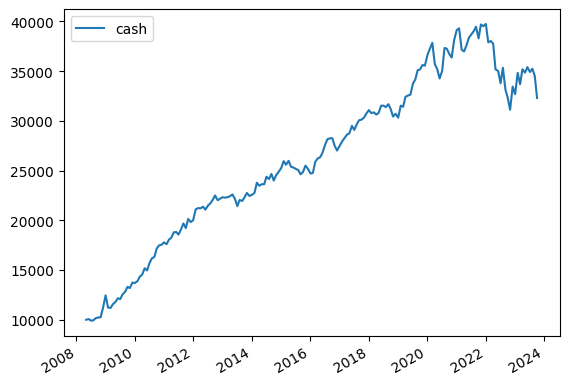

In [13]:
df_cash.plot()